# BCycle Austin stations

This notebook looks at the stations that make up the Austin BCycle network. For each station we have the following information:

* `station_id`: A unique identifier for each of the station. Used to connect the `bikes.csv` time-varying table to the static `stations` table.
* `name`: The name of the station. This is the nearest cross street to the station, or if the station is located at a building, the name of that building.
* `address`: The address of the station. Note that if a company sponsors the station, it will include their name, for example 'Presented by Whole Foods Market'. For this reason, its best not to geocode this field to a lat/lon pair, and use those values from the respective fields.
* `lat`: The latitude of the station.
* `lon`: The longitude of the station.
* `datetime`: The date and time that the station was first reported when fetching the BCycle Station webpage.

## Imports and data loading

Before getting started, let's import some useful libraries (including the bcycle_lib created for these notebooks), and load the stations CSV file.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the stations table, and show the first 10 entries
stations_df = load_stations()
num_stations = stations_df.shape[0]
print('Found {} stations, showing first 10'.format(num_stations))
stations_df.head(10)


Found 50 stations, showing first 10


,station_id,name,address,lat,lon,datetime
0,1,2nd & Congress,"151 E. 2nd St, Austin, TX 78701",30.264080,-97.743553,2016-04-01
1,2,4th & Congress,"120 W. 4th St., Austin, TX 78701",30.266340,-97.743782,2016-04-01
2,3,8th & Congress,"111 E. 8th St., Austin, TX 78701",30.269800,-97.741859,2016-04-01
3,4,Capitol Station / Congress & 11th,"1090 Congress Ave., Austin, TX 78701",30.272600,-97.741272,2016-04-01
4,5,City Hall / Lavaca & 2nd,"Presented by Graves Dougherty Hearon & Moody, ...",30.264759,-97.746780,2016-04-01
5,6,5th & Bowie,"Presented by Whole Foods Market, Austin, TX 78703",30.269600,-97.753319,2016-04-01
6,7,Barton Springs & Riverside,"400 Barton Springs Rd., Austin, TX 78704",30.258699,-97.748718,2016-04-01
7,8,South Congress & James,"Presented by The Austin Chronicle, Austin, TX ...",30.251030,-97.749260,2016-04-01
8,9,South Congress & Elizabeth,"101 Elizabeth St. W, Austin, TX 78704",30.248911,-97.750191,2016-04-01
9,10,Waller & 6th St.,"602 Waller St., Austin, TX 78702",30.264610,-97.730492,2016-04-01


## How far away are the stations from each other?

We can use the haversine formulat to calculate the distance from each station to every other station. As the distance from one station to another doesn't matter on the order of the stations, the distance matrix will be symmetric about the diagonal. This is because the distance from `station_id 1` to 10 is the same as from `station_id` 10 to 1. 

This cell builds up a matrix of distances which we can plot and investigate.


In [28]:
dist_matrix = np.zeros((num_stations, num_stations))

for i in range(num_stations):
    for j in range(num_stations):
#         print('Processing station {} and {}'.format(i, j))
        dist_matrix[i,j] = haversine_dist(stations_df['lat'][i],
                                          stations_df['lon'][i],
                                          stations_df['lat'][j],
                                          stations_df['lon'][j])
        
print('Distance matrix is: \n{}'.format(dist_matrix))
print('Largest distance is: {:.2f} miles'.format(np.max(dist_matrix)))


Distance matrix is: 
[[ 0.          0.15685034  0.40817399 ...,  0.26772584  0.35901644
   1.2896909 ]
 [ 0.15685034  0.          0.26531403 ...,  0.1575312   0.26761106
   1.1420961 ]
 [ 0.40817399  0.26531403  0.         ...,  0.15742079  0.40138038
   0.99961934]
 ..., 
 [ 0.26772584  0.1575312   0.15742079 ...,  0.          0.38857553
   1.13730807]
 [ 0.35901644  0.26761106  0.40138038 ...,  0.38857553  0.          0.97546735]
 [ 1.2896909   1.1420961   0.99961934 ...,  1.13730807  0.97546735  0.        ]]
Largest distance is: 3.81


## Plot the stations on a map of Austin

Let's plot all the stations on an Open Street Map of Austin, to see where they're concentrated. 

As you'd expect, there are a large cluster of stations in the downtown area. Austin's downtown is a mixture of residential and business buildings, so this could be for commute start and end points. 

There's also a line of stations extending east from the downtown area, along East 5th Street (east of I-35). This also follows the light rail line, which allows people to take the train into Austin, and complete the last mile or two on a bike if their work is further than walking distance from a station.

The UT Austin campus has its own cluster of stations, as it's a short ride from the downtown area, and students may use it to cycle downtown.

Finally, there are stations clustered in and around Zilker park, and the Town Lake cycle and footpath. People might use these bikes recreationally. There is also a set of stations extending on South Congress, where car parking is a known problem, and there are a lot of restaurants and stores.

In [58]:
# First find the minimum and maximum lat/lon values for each of the stations
min_lat = stations_df['lat'].min()
max_lat = stations_df['lat'].max()
min_lon = stations_df['lon'].min()
max_lon = stations_df['lon'].max()

center_lat = min_lat + (max_lat - min_lat) / 2.0
center_lon = min_lon + (max_lon - min_lon) / 2.0

# create empty map zoomed in on San Francisco
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

for station in stations_df.iterrows():
    folium.Marker([station[1]['lat'], station[1]['lon']],
              popup=station[1]['name'],
              icon=folium.Icon(icon='info-sign')
             ).add_to(map)
map

In [7]:
station1_df = bike_pivot_df['bikes', 1]
station1_df.head()
type(station1_df)

pandas.core.series.Series

In [8]:
station1_df.resample('H').min().head()


datetime
2016-04-01 00:00:00    6.0
2016-04-01 01:00:00    6.0
2016-04-01 02:00:00    3.0
2016-04-01 03:00:00    3.0
2016-04-01 04:00:00    3.0
Freq: H, Name: (bikes, 1), dtype: float64

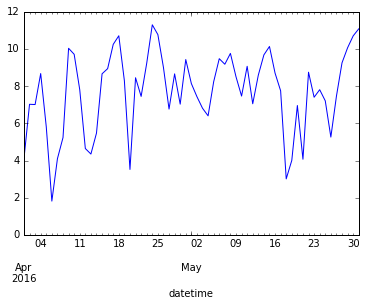

In [23]:
station1_df.resample('D').mean().plot()

In [65]:
stations_df.head()

,station_id,name,address,lat,lon,datetime
0,1,2nd & Congress,"151 E. 2nd St, Austin, TX 78701",30.264080,-97.743553,2016-04-01 00:00:00
1,2,4th & Congress,"120 W. 4th St., Austin, TX 78701",30.266340,-97.743782,2016-04-01 00:00:00
2,3,8th & Congress,"111 E. 8th St., Austin, TX 78701",30.269800,-97.741859,2016-04-01 00:00:00
3,4,Capitol Station / Congress & 11th,"1090 Congress Ave., Austin, TX 78701",30.272600,-97.741272,2016-04-01 00:00:00
4,5,City Hall / Lavaca & 2nd,"Presented by Graves Dougherty Hearon & Moody, ...",30.264759,-97.746780,2016-04-01 00:00:00


In [75]:
daily_bike_checkouts = (bike_pivot_df['bikes']
                        .diff(axis=0)
                        .abs()
                        .resample('D')
                        .sum()
                        )
daily_bike_checkouts.columns = stations_df['name']
daily_bike_checkouts.head()

name,2nd & Congress,4th & Congress,8th & Congress,Capitol Station / Congress & 11th,City Hall / Lavaca & 2nd,5th & Bowie,Barton Springs & Riverside,South Congress & James,South Congress & Elizabeth,Waller & 6th St.,...,Capital Metro HQ - East 5th at Broadway,11th & San Jacinto,East 4th & Chicon,East 2nd & Pedernales,Lavaca & 6th,MoPac Pedestrian Bridge @ Veterans Drive,East 7th & Pleasant Valley,Brazos & 6th,Republic Square,Pease Park
datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-01,26.0,31.0,11.0,18.0,35.0,31.0,13.0,10.0,14.0,11.0,...,4.0,8.0,6.0,4.0,8.0,3.0,3.0,18.0,NaN,NaN
2016-04-02,63.0,51.0,36.0,25.0,55.0,37.0,31.0,35.0,44.0,39.0,...,0.0,15.0,21.0,11.0,12.0,56.0,5.0,35.0,NaN,NaN
2016-04-03,79.0,33.0,8.0,44.0,69.0,36.0,59.0,30.0,32.0,16.0,...,0.0,12.0,40.0,12.0,19.0,69.0,0.0,57.0,NaN,NaN
2016-04-04,49.0,45.0,11.0,29.0,74.0,46.0,28.0,19.0,22.0,16.0,...,6.0,6.0,10.0,13.0,16.0,25.0,3.0,33.0,NaN,NaN
2016-04-05,53.0,60.0,32.0,25.0,42.0,54.0,36.0,17.0,14.0,14.0,...,6.0,5.0,6.0,10.0,26.0,21.0,4.0,34.0,NaN,NaN


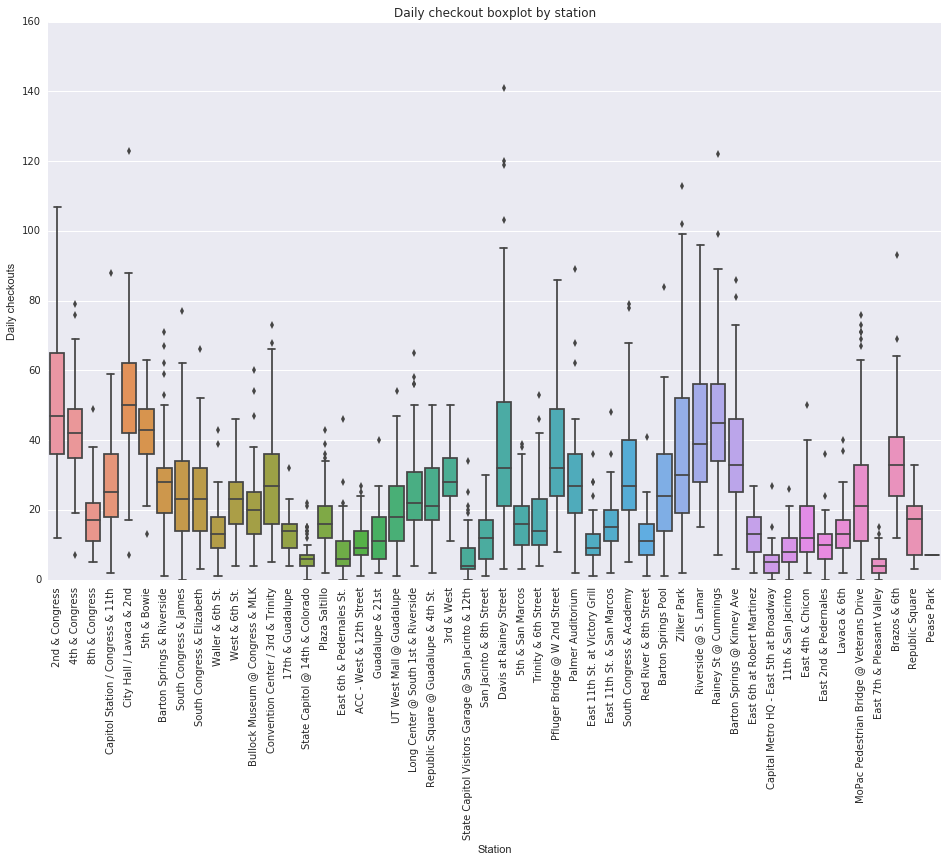

In [93]:
fig, ax = plt.subplots(figsize=(16, 10))
plt.setp(ax.get_xticklabels(), rotation=90)


ax = sns.boxplot(data=daily_bike_checkouts)

ax.set_xlabel('Station')
ax.set_ylabel('Daily checkouts')
ax.set_title('Daily checkout boxplot by station')



In [9]:
bike_pivot_df.head()

bikes                                                 ...  \
station_id             1    2    3    4    5     6     7    8     9    10 ...   
datetime                                                                  ...   
2016-04-01 00:00:00   6.0  5.0  4.0  7.0  8.0  10.0  10.0  8.0  13.0  1.0 ...   
2016-04-01 00:05:00   6.0  5.0  4.0  7.0  8.0  10.0  10.0  8.0  13.0  1.0 ...   
2016-04-01 00:10:00   6.0  5.0  4.0  7.0  8.0  10.0  10.0  8.0  13.0  1.0 ...   
2016-04-01 00:15:00   6.0  5.0  4.0  7.0  8.0  10.0  10.0  8.0  13.0  1.0 ...   
2016-04-01 00:20:00   6.0  5.0  4.0  7.0  8.0  10.0  10.0  8.0  13.0  1.0 ...   

                    docks                                             
station_id             41   42   43   44   45   46   47   48  49  50  
datetime                                                              
2016-04-01 00:00:00   7.0  9.0  0.0  5.0  2.0  9.0  7.0  0.0 NaN NaN  
2016-04-01 00:05:00   7.0  9.0  0.0  5.0  2.0  9.0  7.0  0.0 NaN NaN  
2016-04-01 00:10:00   7.0  9.0  0.0  5.0  2.0  9.0  7.0  0.0 NaN NaN  
2016-04-01 00:15:00   7.0  9.0  0.0  5.0  2.0  9.0  7.0  0.0 NaN NaN  
2016-04-01 00:20:00   7.0  9.0  0.0  5.0  2.0  9.0  7.0  0.0 NaN NaN  

[5 rows x 100 columns]

In [11]:

bike_pivot_mask = bike_pivot_df == 0
bike_pivot_mask.head()

bikes                                                   \
station_id              1      2      3      4      5      6      7      8    
datetime                                                                      
2016-04-01 00:00:00  False  False  False  False  False  False  False  False   
2016-04-01 00:05:00  False  False  False  False  False  False  False  False   
2016-04-01 00:10:00  False  False  False  False  False  False  False  False   
2016-04-01 00:15:00  False  False  False  False  False  False  False  False   
2016-04-01 00:20:00  False  False  False  False  False  False  False  False   

                                   ...    docks                             \
station_id              9      10  ...       41     42    43     44     45   
datetime                           ...                                       
2016-04-01 00:00:00  False  False  ...    False  False  True  False  False   
2016-04-01 00:05:00  False  False  ...    False  False  True  False  False   
2016-04-01 00:10:00  False  False  ...    False  False  True  False  False   
2016-04-01 00:15:00  False  False  ...    False  False  True  False  False   
2016-04-01 00:20:00  False  False  ...    False  False  True  False  False   

                                                       
station_id              46     47    48     49     50  
datetime                                               
2016-04-01 00:00:00  False  False  True  False  False  
2016-04-01 00:05:00  False  False  True  False  False  
2016-04-01 00:10:00  False  False  True  False  False  
2016-04-01 00:15:00  False  False  True  False  False  
2016-04-01 00:20:00  False  False  True  False  False  

[5 rows x 100 columns]